[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/milicagaljak/SpeechCommandRecognition/blob/main/01_main.ipynb)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [ ]:
import tarfile

In [ ]:
# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
!dir

drive  sample_data


In [ ]:
PATH = './drive/MyDrive/ml_dataset/speech_commands_v0.01.tar.gz'

# Extract data from drive

In [ ]:
if PATH.endswith("tar.gz"):
    tar = tarfile.open(PATH, "r:gz")
    tar.extractall('./data/')
    tar.close()

In [ ]:
!ls data/cat/

In [ ]:
data_dir = pathlib.Path('./data/')

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))

commands = [x for x in commands if x not in {'LICENSE', 'README.md', 'validation_list.txt', 'testing_list.txt', '_background_noise_', 'two', 'three', 'tree'}]
# commands = [x for x in commands if x in {'cat', 'two'}]
print(commands)
print(len(commands))

['cat', 'marvin', 'down', 'yes', 'eight', 'right', 'stop', 'one', 'off', 'go', 'left', 'wow', 'up', 'six', 'on', 'house', 'dog', 'nine', 'happy', 'seven', 'bed', 'no', 'four', 'bird', 'sheila', 'zero', 'five']
27


Extract the audio files into a list and shuffle it.

Number of total examples: 58259


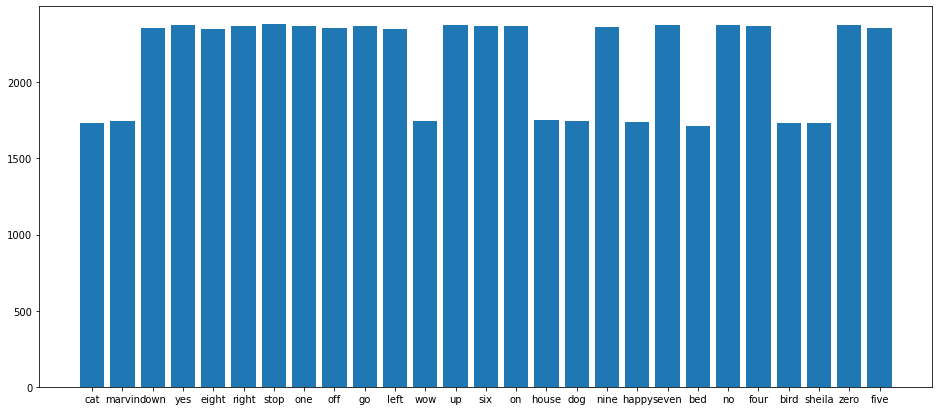

Example file tensor: tf.Tensor(b'data/nine/6c0f6493_nohash_2.wav', shape=(), dtype=string)


In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + '/[^RLv_t]*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
distribution = []
for i in range(0, len(commands)):
  #print("Number of examples per label - {} : {}".format(commands[i], len(tf.io.gfile.listdir(str(data_dir/commands[i])))))
  distribution.append(len(tf.io.gfile.listdir(str(data_dir/commands[i]))))
#print(distribution)

plt.figure(figsize=(16,7))
plt.bar(commands, distribution,width=0.8)
plt.show()
print('Example file tensor:', filenames[0])

Split the files into training, validation and test sets using a 80:10:10 ratio, respectively.

In [ ]:
#print(len(filenames))
train_files = filenames[:int(num_samples*0.8)]
val_files = filenames[int(num_samples*0.8): int(num_samples*0.8 + num_samples*0.1)]
test_files = filenames[int(-num_samples*0.1 - 1):]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))
#print(len(test_files) + len(val_files) + len(train_files))

Training set size 46607
Validation set size 5826
Test set size 5826


The audio file will initially be read as a binary file, which you'll want to convert into a numerical tensor.
To load an audio file, you will use tf.audio.decode_wav, which returns the WAV-encoded audio as a Tensor and the sample rate.

In [ ]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  #print(tf.shape(tf.squeeze(audio, axis=-1)))
  return tf.squeeze(audio, axis=-1)


The label for each WAV file is its parent directory

In [ ]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  #print(len(parts))
  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]

Let's define a method that will take in the filename of the WAV file and output a tuple containing the audio and labels for supervised training.

In [ ]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  # X instance , y target
  return waveform, label

You will now apply process_path to build your training set to extract the audio-label pairs and check the results. You'll build the validation and test sets using a similar procedure later on.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
print(type(train_files))
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
print(type(files_ds))
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
Tensor("strided_slice:0", shape=(), dtype=int32)
Tensor("Shape_2:0", shape=(1,), dtype=int32)


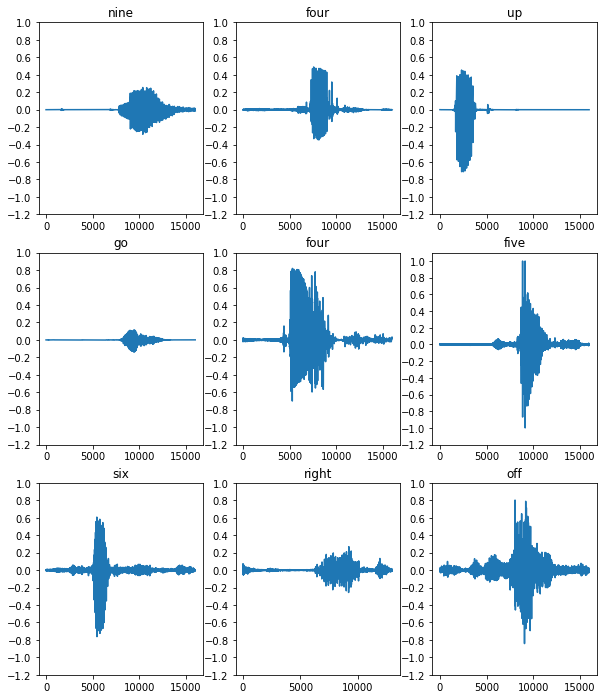

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

# Spectrogram

In [ ]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [ ]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: nine
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


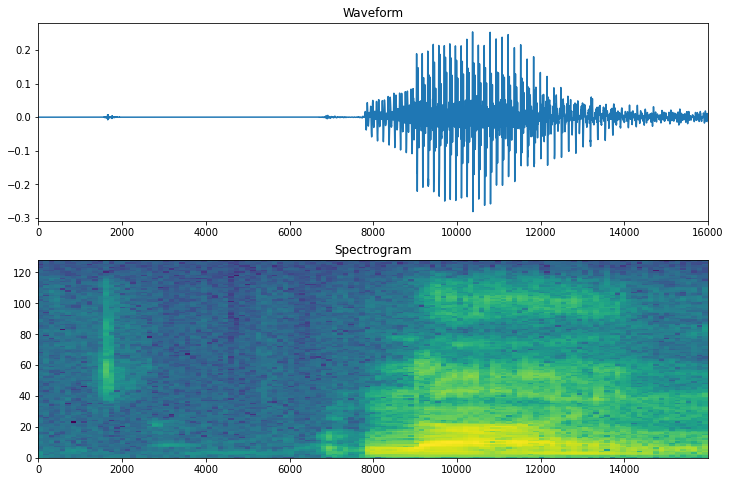

In [ ]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [ ]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


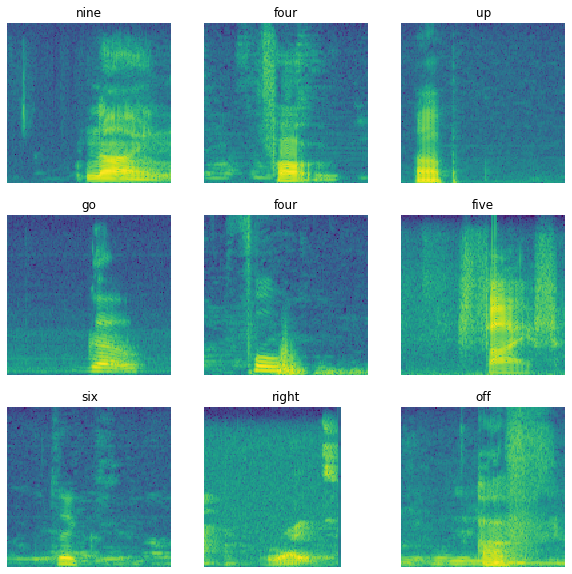

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

# Build and train the mode

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [ ]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [ ]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [ ]:

for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_3 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)        

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
#EPOCHS = 4
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
)

Epoch 1/10
729/729 [==============================] - 133s 183ms/step - loss: 0.7228 - accuracy: 0.7814 - val_loss: 0.5051 - val_accuracy: 0.8586
Epoch 2/10
729/729 [==============================] - 132s 181ms/step - loss: 0.6504 - accuracy: 0.8012 - val_loss: 0.4894 - val_accuracy: 0.8625
Epoch 3/10
729/729 [==============================] - 133s 182ms/step - loss: 0.5948 - accuracy: 0.8196 - val_loss: 0.4526 - val_accuracy: 0.8744
Epoch 4/10
729/729 [==============================] - 132s 180ms/step - loss: 0.5607 - accuracy: 0.8273 - val_loss: 0.4444 - val_accuracy: 0.8769
Epoch 5/10
729/729 [==============================] - 134s 184ms/step - loss: 0.5284 - accuracy: 0.8359 - val_loss: 0.4294 - val_accuracy: 0.8800
Epoch 6/10
729/729 [==============================] - 134s 184ms/step - loss: 0.4969 - accuracy: 0.8453 - val_loss: 0.4195 - val_accuracy: 0.8821
Epoch 7/10
729/729 [==============================] - 134s 183ms/step - loss: 0.4675 - accuracy: 0.8537 - val_loss: 0.4075 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


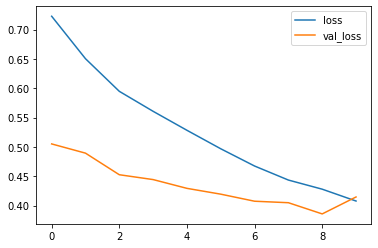

In [ ]:
# epochs 4 + 10
metrics = history.history
print(history.history.keys())
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
0.889289379119873


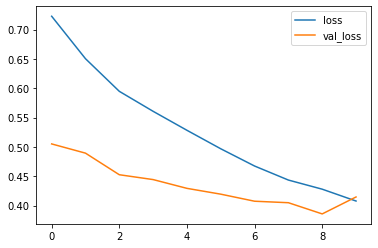

In [ ]:
metrics = history.history
print(history.history.keys())
print(history.history['val_accuracy'][-1])
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

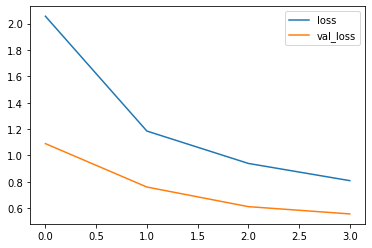

In [ ]:
#epochs 4
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

# Evaluate test set performance

In [ ]:
test_audio = []
test_labels = []
#print(type(test_ds))

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)
# test_audio[91]
# test_labels[91]

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
# print(y_pred)
# print(len(y_pred))
y_true = test_labels
# err_index = y_pred != y_true
# #print(err_index)
# print(len(err_index))
# indexes = list(range(0,len(err_index)))

# #print(indexes)
# map = zip(indexes, err_index )
# for key, value in map:
#   #print (key, value)
#   if value == True:
#      print(key, value)
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.2%}')


Test set accuracy: 88.23%


# Display a confusion matrix

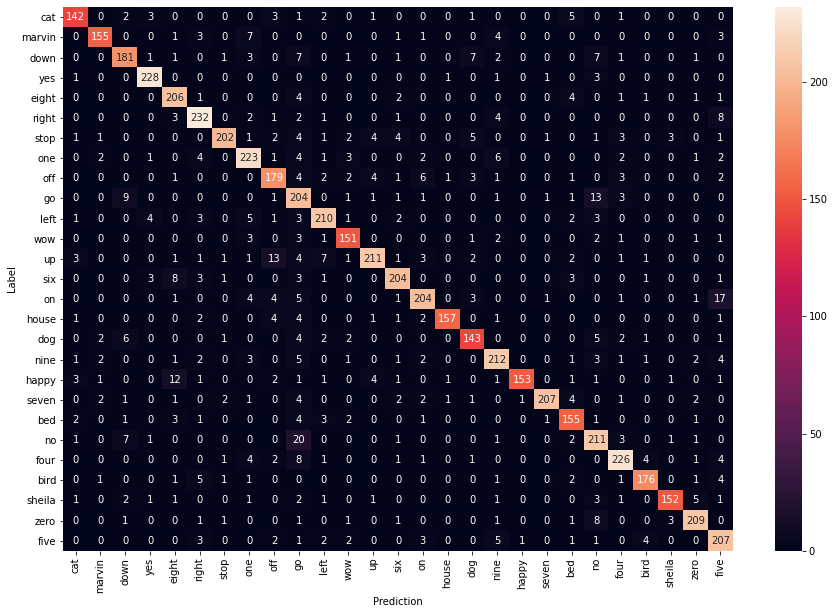

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(15, 10))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# Run inference on an audio file

In [ ]:
# sample_file = './data/two/00b01445_nohash_0.wav'

# sample_ds = preprocess_dataset([str(sample_file)])

# for spectrogram, label in sample_ds.batch(1):
#   prediction = model(spectrogram)
#   plt.bar(commands, tf.nn.softmax(prediction[0]))
#   plt.title(f'Predictions for "{commands[label[0]]}"')
#   plt.show()

In [ ]:
# y_pred = model.predict(test_audio)
# print(y_pred[91])
# #print(y_pred)
# y_pred = np.argmax(model.predict(test_audio), axis = 1)
# print(len(y_pred))
# print(y_pred[91])
# print(y_true[91])